In [1]:
import sys

MAIN_DICT = "/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability"
sys.path.append(MAIN_DICT)

In [2]:
import os
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from utils.load import add_noise, load_data
from utils.params import set_param

warnings.filterwarnings("ignore")

sns.set_theme(style="ticks")
np.random.seed(42)

In [3]:
exp = "p4581"
params = set_param(exp)

dirs = {"main": MAIN_DICT}
dirs["data"] = dirs["main"] + "/data/" + params["dir_data"]

X, Y, t, dt, vl = load_data(exp, dirs, params)
Y = Y[:, 0:2]

In [4]:
df = pd.DataFrame(
    np.hstack((X, Y, t.reshape(-1, 1))),
    columns=[
        "det_shear_stress",
        "obs_shear_stress",
        "obs_normal_stress",
        "time",
    ],
)
df.head()

,det_shear_stress,obs_shear_stress,obs_normal_stress,time
0,0.002811,1.29911,2.99288,0.000
1,0.002731,1.29903,2.99008,0.001
2,0.002231,1.29853,2.98854,0.002
3,0.002411,1.29871,2.98849,0.003
4,0.002241,1.29854,2.99069,0.004


In [5]:
df = df.iloc[::100]

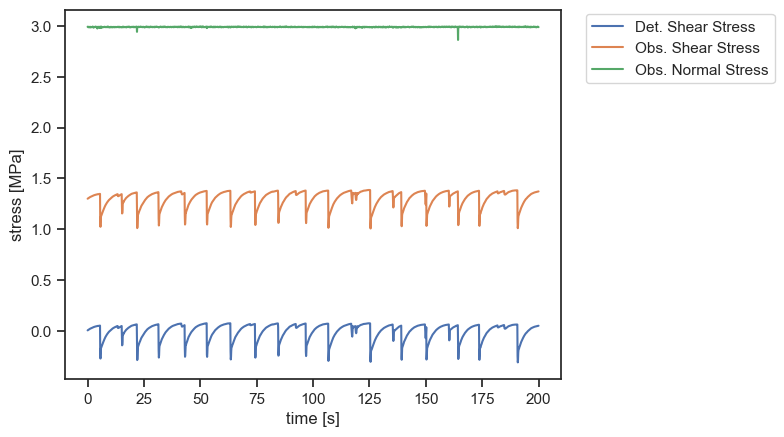

In [6]:
plt.plot(df["time"], df["det_shear_stress"], label="Det. Shear Stress")
plt.plot(df["time"], df["obs_shear_stress"], label="Obs. Shear Stress")
plt.plot(df["time"], df["obs_normal_stress"], label="Obs. Normal Stress")
plt.legend(loc=(1.05, 0.8))
plt.xlabel("time [s]")
plt.ylabel("stress [MPa]")
plt.show()

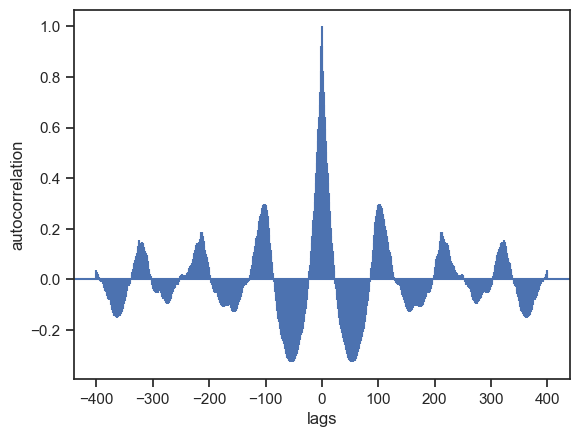

In [7]:
plt.acorr(df["det_shear_stress"], maxlags=400)[1][1]
plt.xlabel("lags")
plt.ylabel("autocorrelation")
plt.show();

In [8]:
RATIO = 0.80
LENGTH = df.shape[0]

train_data = df.iloc[: int(RATIO * LENGTH)]
test_data = df.iloc[int(RATIO * LENGTH) :]

In [9]:
import itertools

import joblib
import optuna
from statsmodels.tsa.holtwinters import ExponentialSmoothing


def objective_holtwinters(trial):
    length = len(train_data)
    train_data_obj = train_data["det_shear_stress"].iloc[: int(RATIO * length)]
    valid_data_obj = train_data["det_shear_stress"].iloc[int(RATIO * length) :]

    smoothing_level = trial.suggest_float("smoothing_level", 0.01, 1.0)
    smoothing_slope = trial.suggest_float("smoothing_slope", 0.01, 1.0)
    smoothing_seasonal = trial.suggest_float("smoothing_seasonal", 0.01, 1.0)
    damping_slope = trial.suggest_float("damping_slope", 0.01, 1.0)
    seasonal_periods = 10

    model = ExponentialSmoothing(
        train_data_obj,
        trend="add",
        seasonal="add",
        seasonal_periods=seasonal_periods,
    ).fit(
        smoothing_level=smoothing_level,
        smoothing_slope=smoothing_slope,
        smoothing_seasonal=smoothing_seasonal,
        damping_slope=damping_slope,
        optimized=True,
    )

    predictions = model.forecast(len(valid_data_obj))
    predictions = pd.Series(predictions, index=valid_data_obj.index)
    residuals = valid_data_obj.values - predictions.values
    mse = np.mean(residuals**2)
    return mse


if os.path.isfile(
    f"{MAIN_DICT}/notebooks/models/p4581_detshearstress_holtwinters_study.pkl"
):
    study = joblib.load(
        f"{MAIN_DICT}/notebooks/models/p4581_detshearstress_holtwinters_study.pkl"
    )
else:
    study = optuna.create_study()
    study.optimize(objective_holtwinters, n_trials=250, timeout=3600)
    joblib.dump(
        study,
        f"{MAIN_DICT}/notebooks/models/p4581_detshearstress_holtwinters_study.pkl",
    )

In [10]:
trial = study.best_trial
print("Accuracy: {}".format(trial.value))
print("Best params for Holt-Winters: {}".format(trial.params))

Accuracy: 0.006835160654503352
Best params for Holt-Winters: {'smoothing_level': 0.6159944133004401, 'smoothing_slope': 0.08214788004271954, 'smoothing_seasonal': 0.2359919105659936, 'damping_slope': 0.6176775044118926}


In [11]:
model = ExponentialSmoothing(
    train_data["det_shear_stress"],
    trend="add",
    seasonal="add",
    seasonal_periods=10,
)

model = model.fit(**trial.params)

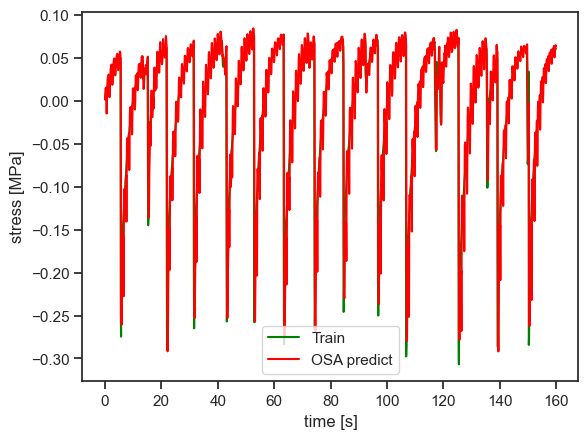

In [12]:
predict_train = model.predict(0, train_data["time"].shape[0])[:-1]

plt.plot(train_data["time"], train_data["det_shear_stress"], color="green")
plt.plot(train_data["time"], predict_train, color="red")
plt.legend(["Train", "OSA predict"])
plt.xlabel("time [s]")
plt.ylabel("stress [MPa]")
plt.show()

In [13]:
from sklearn.metrics import mean_squared_error, r2_score

print(
    f"Train R^2 Score:  {r2_score(predict_train, train_data['det_shear_stress']):.5f}"
)
print(
    f"Train RMSE Score: {np.sqrt(mean_squared_error(predict_train, train_data['det_shear_stress'])):.5f}"
)

Train R^2 Score:  0.78352
Train RMSE Score: 0.03599


In [14]:
import copy

from sklearn.metrics import mean_squared_error
from tqdm import tqdm


def perform_walkforward_validation(train_data, test_data, model):
    predictions = []
    for t in tqdm(range(len(test_data))):
        yhat = model.forecast()[0] if t != 0 else model.forecast().values[0]
        predictions.append(yhat)
        train_data = np.append(train_data, test_data[t : t + 1])
        model = ExponentialSmoothing(
            train_data, trend="add", seasonal="add", seasonal_periods=10
        )
        model = model.fit(**trial.params)
    return predictions


test_model = copy.deepcopy(model)
predict_test = perform_walkforward_validation(
    train_data["det_shear_stress"].values,
    test_data["det_shear_stress"].values,
    test_model,
)

100%|█████████| 401/401 [00:15<00:00, 26.02it/s]


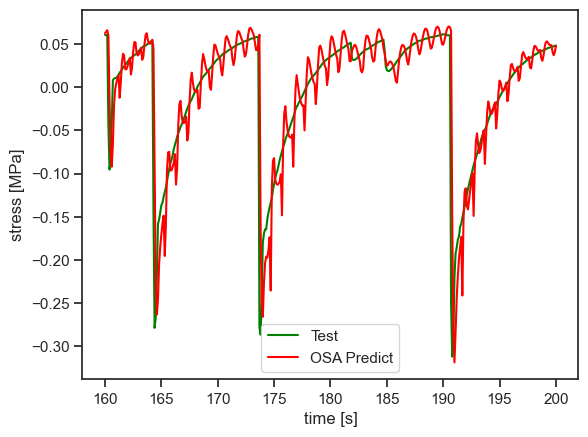

In [15]:
plt.plot(test_data["time"], test_data["det_shear_stress"], color="green")
plt.plot(test_data["time"], predict_test, color="red")
plt.legend(["Test", "OSA Predict"])
plt.xlabel("time [s]")
plt.ylabel("stress [MPa]")
plt.show()

In [16]:
from sklearn.metrics import mean_squared_error, r2_score

print(
    f"Test R^2 Score:  {r2_score(predict_test, test_data['det_shear_stress']):.5f}"
)
print(
    f"Test RMSE Score: {np.sqrt(mean_squared_error(predict_test, test_data['det_shear_stress'])):.5f}"
)

Test R^2 Score:  0.78145
Test RMSE Score: 0.03631


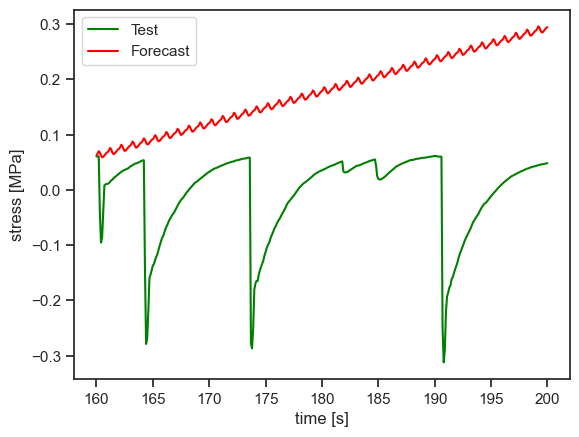

In [17]:
forecasts = model.forecast(len(test_data))
forecasts = pd.Series(forecasts, index=test_data.index)

plt.plot(test_data["time"], test_data["det_shear_stress"], color="green")
plt.plot(test_data["time"], forecasts, color="red")
plt.legend(["Test", "Forecast"])
plt.xlabel("time [s]")
plt.ylabel("stress [MPa]")
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error, r2_score

print(
    f"Forecast R^2 Score:  {r2_score(forecasts, test_data['det_shear_stress']):.5f}"
)
print(
    f"Forecast RMSE Score: {np.sqrt(mean_squared_error(forecasts, test_data['det_shear_stress'])):.5f}"
)

Forecast R^2 Score:  -8.29167
Forecast RMSE Score: 0.20470
